## Task 1: Web Scraping

In [49]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from datetime import datetime
import time

# Define the date range for data collection
data_from = '03/16/2024'
today_date = datetime.now()
data_to = today_date.strftime('%m/%d/%Y')

url = 'http://oasis.caiso.com/mrioasis/default.do?tiny=izbRTw'
cb = webdriver.Chrome()

cb.get(url)
time.sleep(5)  # Wait for the page to load

# Navigate to "SYSTEM DEMAND" 
sys_page = cb.find_element(by=By.XPATH, value='.//*[@data-copy-text="SYSTEM DEMAND"]')
ActionChains(cb).move_to_element(sys_page).perform()
time.sleep(0.5)

# Select "Wind and Solar Forecast" 
wind_page = cb.find_element(by=By.XPATH, value='.//*[@data-copy-text="Wind and Solar Forecast"]')
ActionChains(cb).move_to_element(wind_page).perform()
wind_page.click()
time.sleep(5)

#input the date range; PFC_date_to first
data_to_input = cb.find_element(by=By.XPATH, value='//input[contains(@onchange, "PFC_date_to")]')
ActionChains(cb).move_to_element(data_to_input).perform()
data_to_input.send_keys(Keys.END + Keys.BACK_SPACE * 10)
time.sleep(0.5)
data_to_input.send_keys(data_to)
time.sleep(0.5)

data_from_input = cb.find_element(by=By.XPATH, value='//input[contains(@onchange, "PFC_date_from")]')
ActionChains(cb).move_to_element(data_from_input).perform()
data_from_input.send_keys(Keys.END + Keys.BACK_SPACE * 10)
time.sleep(0.5)
data_from_input.send_keys(data_from)
time.sleep(0.5)


# Click the "Apply" button
apply_button =  cb.find_element(by=By.XPATH, value='//button[@title="Apply"]')
ActionChains(cb).move_to_element(apply_button).perform()
apply_button.click()
time.sleep(15)

# Click the "Download CSV" button to download the data
download_button =  cb.find_element(by=By.XPATH, value='//button[@title="Download CSV"]')
ActionChains(cb).move_to_element(download_button).perform()
download_button.click()
time.sleep(45)
cb.quit()

## Task 2: Prediction

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('20240316_20240409_SLD_REN_FCST_N_20240408_10_21_48_v1.csv')

In [2]:
# Define the criteria for filtering
criteria_hub = df["TRADING_HUB"] == "SP15"
criteria_renewable = df["RENEWABLE_TYPE"] == "Wind"
criteria_market_run_id = df["MARKET_RUN_ID"].isin(["DAM", "ACTUAL"])

# Select relevant columns
new_df = df.loc[criteria_hub & criteria_renewable & criteria_market_run_id, ["OPR_DT", "OPR_HR", "TRADING_HUB", "RENEWABLE_TYPE", "MW", "MARKET_RUN_ID"]]

In [3]:
# Filter rows based on 'Market_Run_ID'
new_df['OPR_DT'] = pd.to_datetime(new_df['OPR_DT'])

wind_actual = new_df[new_df['MARKET_RUN_ID'] == 'ACTUAL']
wind_dam = new_df[new_df['MARKET_RUN_ID'] == 'DAM']

# Select required columns
wind_actual = wind_actual[['OPR_DT', 'OPR_HR', 'TRADING_HUB', 'RENEWABLE_TYPE', 'MW']]
wind_dam = wind_dam[['OPR_DT', 'OPR_HR', 'TRADING_HUB', 'RENEWABLE_TYPE', 'MW']]

# Rename columns
wind_actual.columns = ['DATE', 'HE', 'Trading_Hub', 'Renewable_Type', 'MW']
wind_dam.columns = ['DATE', 'HE', 'Trading_Hub', 'Renewable_Type', 'MW']


In [4]:
wind_actual = wind_actual.sort_values(by=['DATE', 'HE'])    # downlaoded data from 2024-03-16 to 2024-04-08
wind_actual['DATE'] = pd.to_datetime(wind_actual['DATE'])
wind_dam = wind_dam.sort_values(by=['DATE', 'HE'])
wind_dam['DATE'] = pd.to_datetime(wind_dam['DATE'])

In [5]:
provided_actual = pd.read_csv('Wind_Actual.csv')   # provided data from 2023-01-01 to 2024-03-15
provided_actual['DATE'] = pd.to_datetime(provided_actual['DATE'])

provided_dam = pd.read_csv('Wind_Forecast.csv')  
provided_dam['DATE'] = pd.to_datetime(provided_dam['DATE'])

In [6]:

combined_actual = pd.concat([provided_actual, wind_actual], ignore_index=True)  
#conbine the data make it from 2023-01-01 to present
combined_actual = combined_actual.sort_values(by=['DATE', 'HE'])

combined_dam = pd.concat([provided_dam, wind_dam], ignore_index=True)
combined_dam = combined_dam.sort_values(by=['DATE', 'HE'])



In [7]:
dup = combined_actual.duplicated(subset=['DATE','HE'])  #check if duplicated data
print(len(combined_actual[dup]))

dup1 = combined_dam.duplicated(subset=['DATE','HE'])  
print(len(combined_dam[dup1]))

condition = ~(combined_actual['HE'].between(1, 24))  # if error data
print(len(combined_actual[condition]))

condition1 = ~(combined_dam['HE'].between(1, 24))  
print(len(combined_dam[condition1]))

0
0
1
1


In [8]:
combined_actual[condition]

,DATE,HE,Trading_Hub,Renewable_Type,MW
7401,2023-11-05,25,SP15,Wind,3.4


In [9]:
combined_actual[7399:7403]  #from the data, HE in row 7401 should be 24

,DATE,HE,Trading_Hub,Renewable_Type,MW
7399,2023-11-05,22,SP15,Wind,1223.48668
7400,2023-11-05,23,SP15,Wind,1099.47966
7401,2023-11-05,25,SP15,Wind,3.40000
7402,2023-11-06,1,SP15,Wind,1100.29271


In [10]:
combined_actual.loc[combined_actual[condition].index,'HE'] = 24

In [11]:
combined_dam[condition1]

,DATE,HE,Trading_Hub,Renewable_Type,MW
7177,2023-11-05,25,SP15,Wind,1284.6


In [12]:
combined_dam[7176:7179]  #from the data, HE in row 7401 should be 24


,DATE,HE,Trading_Hub,Renewable_Type,MW
7176,2023-11-05,24,SP15,Wind,27.10
7177,2023-11-05,25,SP15,Wind,1284.60
7178,2023-11-06,1,SP15,Wind,1670.44


In [13]:
combined_dam.loc[combined_dam[condition1].index,'HE'] = 24

In [14]:
# Combine 'DATE' and 'HE' columns to create a datetime column
combined_actual['DATETIME'] = pd.to_datetime(combined_actual['DATE']) + pd.to_timedelta(combined_actual['HE'] - 1, unit='h')
combined_dam['DATETIME'] = pd.to_datetime(combined_dam['DATE']) + pd.to_timedelta(combined_dam['HE'] - 1, unit='h')
# Merge combined_actual and combined_dam on the 'DATETIME' column
merged_df = pd.merge(combined_actual, combined_dam[['DATETIME', 'MW']], on='DATETIME', how='left')
merged_df.rename(columns={'MW_x': 'MW','MW_y':'MW_pred'}, inplace=True)
merged_df.head(5)

,DATE,HE,Trading_Hub,Renewable_Type,MW,DATETIME,MW_pred
0,2023-01-01,1,SP15,Wind,2108.04570,2023-01-01 00:00:00,2474.02
1,2023-01-01,2,SP15,Wind,2563.03702,2023-01-01 01:00:00,2581.14
2,2023-01-01,3,SP15,Wind,2799.13237,2023-01-01 02:00:00,2663.81
3,2023-01-01,4,SP15,Wind,2659.33710,2023-01-01 03:00:00,2707.74
4,2023-01-01,5,SP15,Wind,2224.13754,2023-01-01 04:00:00,2717.96


There is lack of some predicted wind data in 2023-03-13 to 2023-11-05 when HE ==1

In [15]:
# Merge combined_actual and combined_dam on the 'DATETIME' column
merged_df = pd.merge(combined_actual, combined_dam[['DATETIME', 'MW']], on='DATETIME', how='left')
merged_df.rename(columns={'MW_x': 'MW','MW_y':'MW_pred'}, inplace=True)
merged_df = merged_df.dropna()
merged_df.head(5)

,DATE,HE,Trading_Hub,Renewable_Type,MW,DATETIME,MW_pred
0,2023-01-01,1,SP15,Wind,2108.04570,2023-01-01 00:00:00,2474.02
1,2023-01-01,2,SP15,Wind,2563.03702,2023-01-01 01:00:00,2581.14
2,2023-01-01,3,SP15,Wind,2799.13237,2023-01-01 02:00:00,2663.81
3,2023-01-01,4,SP15,Wind,2659.33710,2023-01-01 03:00:00,2707.74
4,2023-01-01,5,SP15,Wind,2224.13754,2023-01-01 04:00:00,2717.96


### Visualization( provided predicted wind vs. actual wind)

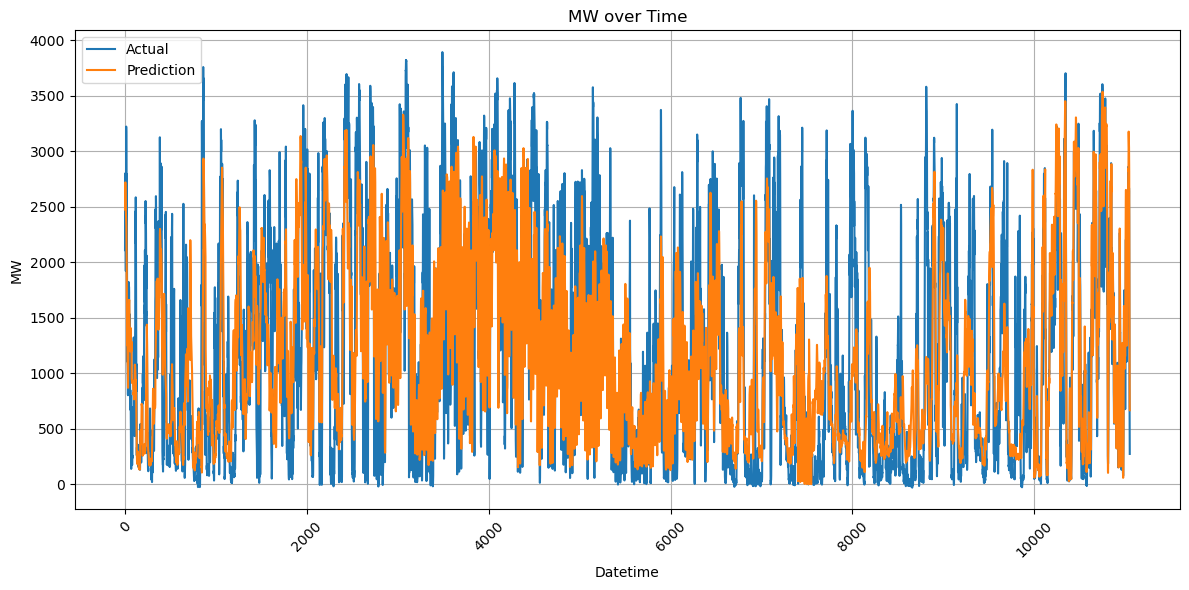

MSE between provided predicted MW and actual MW is 0.4734999255262979


In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import StandardScaler


# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, merged_df['MW'], linestyle='-',label="Actual")
plt.plot(merged_df.index, merged_df['MW_pred'], linestyle='-',label="Prediction")
plt.title('MW over Time')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#standardish the actual and predicted data to see the MSE
scaler = StandardScaler()


combined_actual_scaled = scaler.fit_transform(np.array(merged_df['MW']).reshape(-1, 1))
combined_dam_scaled =  scaler.transform(np.array(merged_df['MW_pred']).reshape(-1, 1).reshape(-1, 1))


error = mean_squared_error(combined_actual_scaled,combined_dam_scaled) 
print("MSE between provided predicted MW and actual MW is {}".format(error))

Provided predicted wind data has a small mean squared error (MSE), which is pretty good. I will try to make the MSE of my model as close to 0.47 as possible

### Feature Engineering

In [17]:
combined_actual['chg_1h'] = (combined_actual['MW'] - combined_actual['MW'].shift(1))/combined_actual['MW'].shift(1)
combined_actual['chg_1d'] = (combined_actual['MW'] - combined_actual['MW'].shift(24))/combined_actual['MW'].shift(24)
combined_actual['chg_1w'] = (combined_actual['MW'] - combined_actual['MW'].shift(24*7))/combined_actual['MW'].shift(24*7)
combined_actual['chg_1m'] = (combined_actual['MW'] - combined_actual['MW'].shift(24*30))/combined_actual['MW'].shift(24*30)

combined_actual['mean_24h'] = combined_actual['MW'].rolling(window=24).mean()
combined_actual['mean_36h'] = combined_actual['MW'].rolling(window=36).mean()
combined_actual['mean_48h'] = combined_actual['MW'].rolling(window=48).mean()

combined_actual['lag_1h'] = combined_actual['MW'].shift(1)
combined_actual['lag_1d'] = combined_actual['MW'].shift(24)
combined_actual['lag_3d'] = combined_actual['MW'].shift(24*3)
combined_actual['lag_1w'] = combined_actual['MW'].shift(24*7)
combined_actual['lag_1m'] = combined_actual['MW'].shift(24*30)


In [18]:
combined_actual["Year"] = combined_actual["DATE"].dt.year
combined_actual["Month"] = combined_actual["DATE"].dt.month
combined_actual["Day"] = combined_actual["DATE"].dt.day
combined_actual['Weekdays'] = combined_actual['DATE'].dt.weekday
combined_actual['Dayofyear'] = combined_actual['DATE'].dt.dayofyear

In [19]:
combined_actual['pred'] = combined_actual['MW'].shift(-48)

In [20]:
test = combined_actual.copy()  # it will be used to predict 2024-04-09 wind

In [21]:
combined_actual = combined_actual.dropna()

In [22]:
combined_actual

,DATE,HE,Trading_Hub,Renewable_Type,MW,DATETIME,chg_1h,chg_1d,chg_1w,chg_1m,...,lag_1d,lag_3d,lag_1w,lag_1m,Year,Month,Day,Weekdays,Dayofyear,pred
720,2023-01-31,3,SP15,Wind,541.23901,2023-01-31 02:00:00,0.300154,0.543095,1.122837,-0.743251,...,350.74897,816.01324,254.96027,2108.04570,2023,1,31,1,31,64.82706
721,2023-01-31,4,SP15,Wind,493.38512,2023-01-31 03:00:00,-0.088415,1.174106,1.104080,-0.807500,...,226.93697,859.03793,234.48970,2563.03702,2023,1,31,1,31,115.28795
722,2023-01-31,5,SP15,Wind,496.79326,2023-01-31 04:00:00,0.006908,1.262084,1.180744,-0.822519,...,219.61749,829.09367,227.80903,2799.13237,2023,1,31,1,31,162.50984
723,2023-01-31,6,SP15,Wind,540.13362,2023-01-31 05:00:00,0.087240,1.137427,1.715513,-0.796892,...,252.70270,495.58693,198.90667,2659.33710,2023,1,31,1,31,164.24392
724,2023-01-31,7,SP15,Wind,560.60969,2023-01-31 06:00:00,0.037909,0.438746,2.285441,-0.747943,...,389.65151,420.74577,170.63451,2224.13754,2023,1,31,1,31,135.94279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10996,2024-04-04,7,SP15,Wind,1057.12544,2024-04-04 06:00:00,-0.279841,4.392878,-0.393161,-0.518834,...,196.02249,239.30432,1742.01942,2197.00810,2024,4,4,3,95,1196.33820
10997,2024-04-04,8,SP15,Wind,1081.25118,2024-04-04 07:00:00,0.022822,9.015747,-0.384903,-0.475866,...,107.95512,222.71629,1757.85434,2062.92971,2024,4,4,3,95,893.83478
10998,2024-04-04,9,SP15,Wind,675.69262,2024-04-04 08:00:00,-0.375083,7.443977,-0.578835,-0.712529,...,80.02066,209.00240,1604.34000,2350.46959,2024,4,4,3,95,597.76907
10999,2024-04-04,10,SP15,Wind,1039.68761,2024-04-04 09:00:00,0.538699,12.676368,-0.255790,-0.582231,...,76.02074,300.02482,1397.03532,2488.66747,2024,4,4,3,95,336.62773


In [24]:
data = combined_actual[['DATETIME','HE','MW','chg_1h','chg_1d','chg_1w','mean_24h',
                        'mean_36h','mean_48h','Year','Month','Day','Weekdays','Dayofyear',
                        'lag_1h','lag_1d','lag_3d','lag_1w','lag_1m','pred']]

In [26]:
data.head()

,DATETIME,HE,MW,chg_1h,chg_1d,chg_1w,mean_24h,mean_36h,mean_48h,Year,Month,Day,Weekdays,Dayofyear,lag_1h,lag_1d,lag_3d,lag_1w,lag_1m,pred
720,2023-01-31 02:00:00,3,541.23901,0.300154,0.543095,1.122837,552.271539,631.175984,927.987670,2023,1,31,1,31,416.28828,350.74897,816.01324,254.96027,2108.04570,64.82706
721,2023-01-31 03:00:00,4,493.38512,-0.088415,1.174106,1.104080,563.373545,604.376397,899.509824,2023,1,31,1,31,541.23901,226.93697,859.03793,234.48970,2563.03702,115.28795
722,2023-01-31 04:00:00,5,496.79326,0.006908,1.262084,1.180744,574.922535,591.645079,875.442786,2023,1,31,1,31,493.38512,219.61749,829.09367,227.80903,2799.13237,162.50984
723,2023-01-31 05:00:00,6,540.13362,0.087240,1.137427,1.715513,586.898824,580.010089,850.956124,2023,1,31,1,31,496.79326,252.70270,495.58693,198.90667,2659.33710,164.24392
724,2023-01-31 06:00:00,7,560.60969,0.037909,0.438746,2.285441,594.022081,566.180234,823.121822,2023,1,31,1,31,540.13362,389.65151,420.74577,170.63451,2224.13754,135.94279


In [27]:
X = np.array(data)[:,1:-1]
y = np.array(data)[:,-1]

In [28]:
n = int(len(X)*0.7)
X_train = X[:n,:]
X_test = X[n:,:]
y_train = y[:n]
y_test = y[n:]

In [29]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
scaler1 = StandardScaler()

# Fit the scaler on the training data and transform it
X_scaled = scaler.fit_transform(X_train)
y_scaled = scaler1.fit_transform(y_train.reshape(-1, 1))

# Apply the same transformation to the test data
# (only transform, don't fit again)
X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler1.transform(y_test.reshape(-1, 1))

In [30]:
def create_3d_dataset(data, time_steps):
    X = []
    for i in range(len(data) - time_steps+1):
        x_i = data[i:i + time_steps, :]
        
        X.append(x_i)
    
    return np.array(X)

time_step = 24*3
X_train_1 = create_3d_dataset(X_scaled,time_step)
y_train_1 = y_scaled[time_step-1:]

X_test_1 = create_3d_dataset(X_test_scaled,time_step)
y_test_1 = y_test_scaled[time_step-1:]


In [31]:
y_test_1

array([[-0.30755399],
       [-0.60363151],
       [-0.85864464],
       ...,
       [-0.70670989],
       [-0.96776964],
       [-1.03209554]])

### CNN

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, BatchNormalization, ReLU, Flatten, Dense, Dropout

model_CNN = Sequential()

# First block
model_CNN.add(Dropout(0.5, input_shape=(X_train_1.shape[1], X_train_1.shape[2])))
model_CNN.add(Conv1D(32, 11, padding='same'))
model_CNN.add(BatchNormalization())
model_CNN.add(ReLU())
model_CNN.add(AveragePooling1D(2))

# Second block
model_CNN.add(Dropout(0.5))
model_CNN.add(Conv1D(64, 9, padding='same'))
model_CNN.add(BatchNormalization())
model_CNN.add(ReLU())
model_CNN.add(AveragePooling1D(2))

# Third block
model_CNN.add(Dropout(0.5))
model_CNN.add(Conv1D(128, 5, padding='same'))
model_CNN.add(BatchNormalization())
model_CNN.add(ReLU())
model_CNN.add(AveragePooling1D(2))

# Fourth block
model_CNN.add(Dropout(0.5))
model_CNN.add(Conv1D(256, 3, padding='same'))
model_CNN.add(BatchNormalization())
model_CNN.add(ReLU())
model_CNN.add(AveragePooling1D(2))

model_CNN.add(Flatten())

# Fully connected layers
model_CNN.add(Dense(32, activation='relu'))
model_CNN.add(Dense(16, activation='relu'))
model_CNN.add(Dense(1, activation='linear')) 

model_CNN.compile(optimizer='adam', loss='mse') 
model_CNN.summary()


mod1 = model_CNN.fit(X_train_1, 
                  y_train_1, 
                  epochs=20, 
                  batch_size=24*7, 
                  validation_data=(X_test_1, y_test_1),
                  shuffle= False)

predict_CNN = model_CNN.predict(X_test_1)
predictions_CNN = scaler1.inverse_transform(predict_CNN)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 72, 18)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 72, 32)            6368      
                                                                 
 batch_normalization_4 (Batc  (None, 72, 32)           128       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 72, 32)            0         
                                                                 
 average_pooling1d_4 (Averag  (None, 36, 32)           0         
 ePooling1D)                                                     
                                                                 
 dropout_5 (Dropout)         (None, 36, 32)           

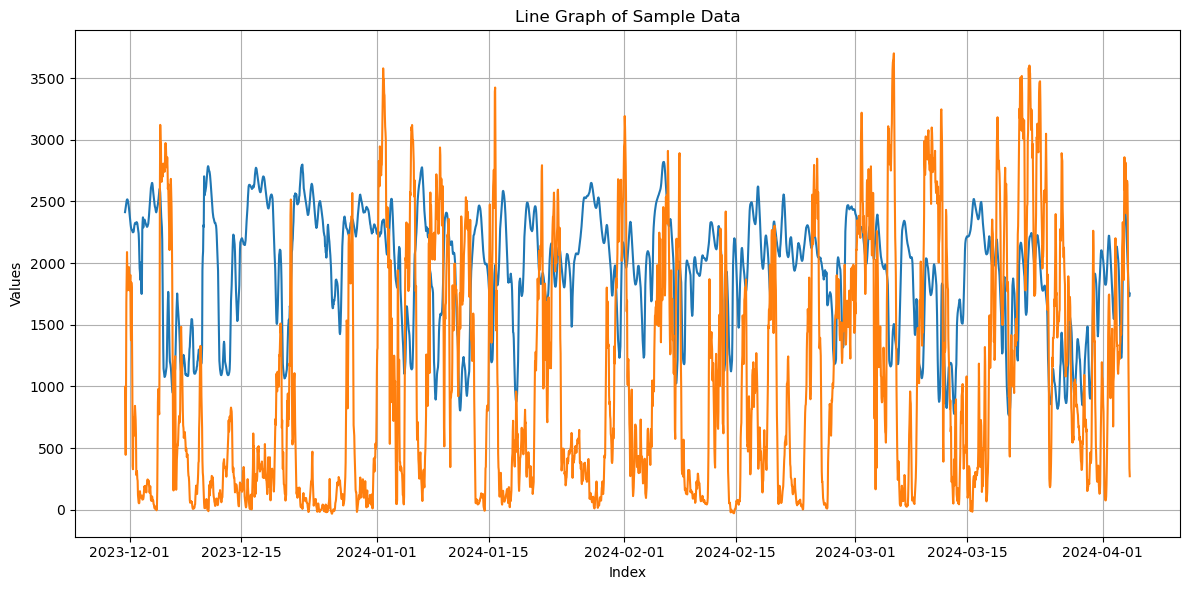

MSE between provided CNN prediction and actual MW is 2.096113299961054


In [36]:
x = np.array([i for i in range(len(predictions_CNN))])
# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_CNN):], predictions_CNN)
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_CNN):], scaler1.inverse_transform(y_test_1))

plt.title('Line Graph of Sample Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


error_CNN = mean_squared_error(y_test_1,predict_CNN) 
print("MSE between provided CNN prediction and actual MW is {}".format(error_CNN))



###  RNN(LSTM)

RNN might be better for the time-series predictions

In [37]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
# from tensorflow.keras.layers import 
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
import pandas as pd
import numpy as np

model_RNN = Sequential()


model_RNN.add(LSTM(units=16, input_shape=(X_train_1.shape[1], X_train_1.shape[2]), return_sequences=True))
model_RNN.add(Dropout(0.5))
model_RNN.add(LSTM(units=16))
model_RNN.add(Dropout(0.5))

# Output layer
model_RNN.add(Dense(units=1, activation="relu"))
model_RNN.compile(loss='mse', optimizer='adam')

# Train the model
mod = model_RNN.fit(X_train_1, 
                y_train_1, 
                   epochs=20, 
                   batch_size=24*7, 
                   validation_data=(X_test_1, y_test_1),
                   shuffle= False)

# Make predictions on the test set
predict_RNN = model_RNN.predict(X_test_1)
predictions_RNN = scaler1.inverse_transform(predict_RNN)

Epoch 1/20
43/43 [==============================] - 6s 70ms/step - loss: 1.0335 - val_loss: 0.9680
Epoch 2/20
43/43 [==============================] - 2s 50ms/step - loss: 0.9884 - val_loss: 0.9744
Epoch 3/20
43/43 [==============================] - 2s 51ms/step - loss: 0.9847 - val_loss: 0.9777
Epoch 4/20
43/43 [==============================] - 2s 51ms/step - loss: 0.9737 - val_loss: 0.9861
Epoch 5/20
43/43 [==============================] - 2s 50ms/step - loss: 0.9565 - val_loss: 0.9992
Epoch 6/20
43/43 [==============================] - 2s 50ms/step - loss: 0.9351 - val_loss: 0.9956
Epoch 7/20
43/43 [==============================] - 2s 51ms/step - loss: 0.9148 - val_loss: 1.0101
Epoch 8/20
43/43 [==============================] - 2s 50ms/step - loss: 0.8947 - val_loss: 1.0387
Epoch 9/20
43/43 [==============================] - 2s 51ms/step - loss: 0.8763 - val_loss: 1.0256
Epoch 10/20
43/43 [==============================] - 2s 51ms/step - loss: 0.8686 - val_loss: 1.0587
Epoch 11/

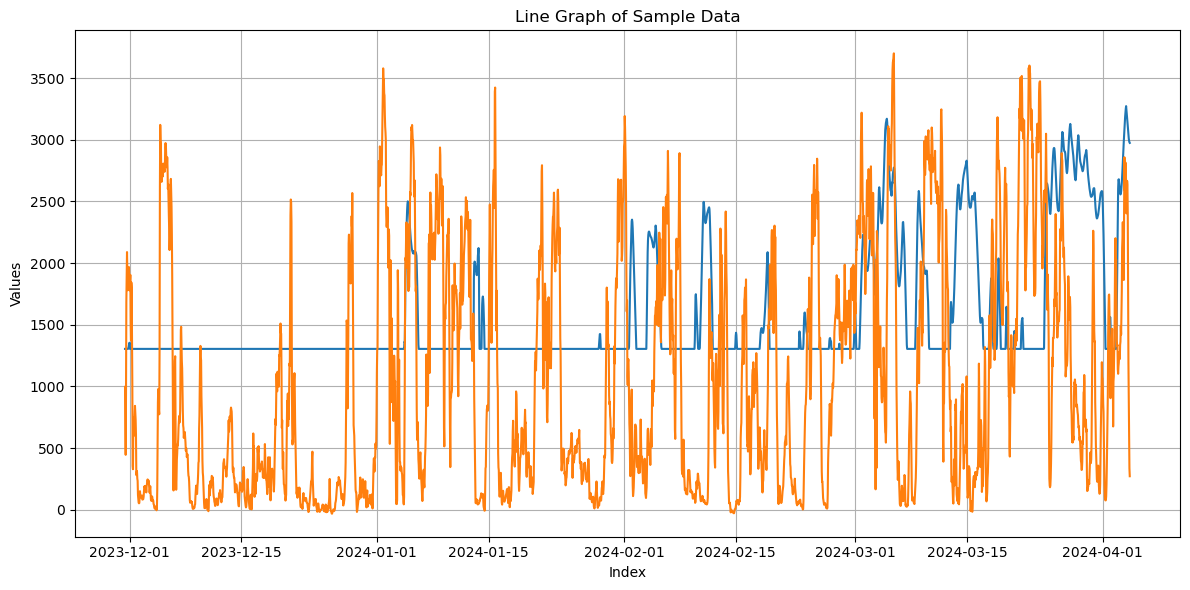

MSE between provided CNN prediction and actual MW is 1.278399820968871


In [38]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([i for i in range(len(predictions_RNN))])
# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_RNN):], predictions_RNN)
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_RNN):], scaler1.inverse_transform(y_test_1))

plt.title('Line Graph of Sample Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()

error_RNN = mean_squared_error(y_test_1,predict_RNN) 
print("MSE between provided CNN prediction and actual MW is {}".format(error_RNN))



### CNN + LSTM

In [39]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, LSTM, Dense


model = Sequential()


model.add(Reshape((X_train_1.shape[1], X_train_1.shape[2], 1), input_shape=(X_train_1.shape[1], X_train_1.shape[2])))  
model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding="same", activation="tanh"))
model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
model.add(Conv2D(filters=64, kernel_size=(2,1), strides=1, padding="same", activation="tanh"))
model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
model.add(ReLU())
model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))


# Reshape layer to fit LSTM requirements

model.add(Reshape((X_train_1.shape[1], -1))) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1)) 
#model.add(Dense(units=1, activation="relu"))
# Compile the model (assuming a regression problem; adjust as needed)
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Train the model
mod = model.fit(X_train_1, 
                y_train_1, 
                   epochs=20, 
                   batch_size=120, 
                   validation_data=(X_test_1, y_test_1),
                   shuffle= False)

predict = model.predict(X_test_1)
predictions = scaler1.inverse_transform(predict)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 72, 18, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 72, 18, 64)        192       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 18, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 18, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 18, 64)       0         
 2D)                                                             
                                                                 
 re_lu_8 (ReLU)              (None, 72, 18, 64)       

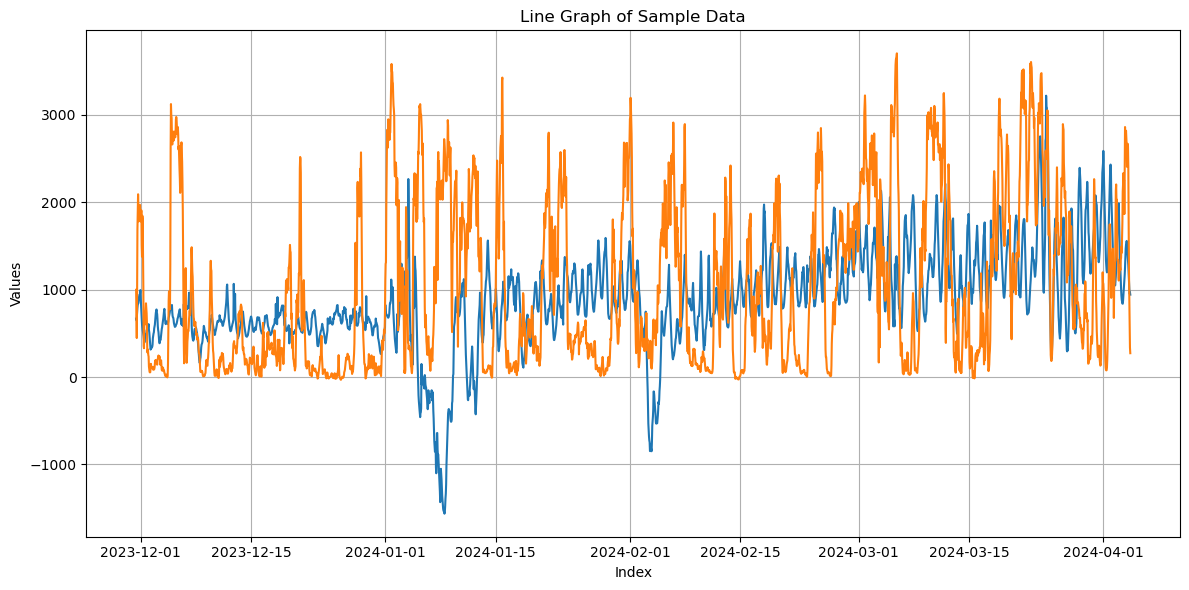

MSE between provided CNN prediction and actual MW is 1.0895151790980206


In [41]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([i for i in range(len(predictions))])
# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions):], predictions.reshape(-1))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions):], scaler1.inverse_transform(y_test_1))
#plt.plot(combined_actual['DATETIME'].iloc[-len(predictions):], combined_dam['MW'].iloc[-len(predictions):])

plt.title('Line Graph of Sample Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


error = mean_squared_error(y_test_1,predict) 
print("MSE between provided CNN prediction and actual MW is {}".format(error))



### find the optimal parameter for CNN+LSTM

In [43]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Reshape, Conv2D, MaxPooling2D, LSTM, Dense, ReLU

class MyCNNLSTMHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        model = Sequential()
        

        model.add(Reshape((self.input_shape[0], self.input_shape[1], 1), input_shape=(self.input_shape[0], self.input_shape[1])))  
        # First Conv2D block
        model.add(Conv2D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
                         kernel_size=(hp.Choice('kernel_size_1_x', [2, 3]),
                                      hp.Choice('kernel_size_1_y', [1])),
                         strides=1, padding="same", activation="tanh"))
        model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
        
        # Second Conv2D block
        model.add(Conv2D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
                         kernel_size=(hp.Choice('kernel_size_2_x', [2, 3]),
                                      hp.Choice('kernel_size_2_y', [1])),
                         strides=1, padding="same", activation="tanh"))
        model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
        
        
        model.add(ReLU())
        model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
        
        model.add(ReLU())
        model.add(MaxPooling2D(pool_size=(2,1), strides=1, padding="same"))
        
        model.add(Reshape((self.input_shape[1], -1)))
        model.add(LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False, activation="relu"))
        
        model.add(Dense(hp.Int('dense_units_1', min_value=16, max_value=64, step=16), activation="relu"))
        model.add(Dense(1))  
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        return model


input_shape = (X_train_1.shape[1], X_train_1.shape[2])

# Initialize the tuner
tuner = kt.RandomSearch(
    MyCNNLSTMHyperModel(input_shape=input_shape),
    objective='val_loss',
    max_trials=100,  
    executions_per_trial=2,  
    directory='my_cnn_lstm_tuner',
    project_name='cnn_lstm_tuning'
)

# Start the search 
tuner.search(X_train_1, y_train_1, epochs=20, validation_data=(X_test_1, y_test_1), shuffle=False)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 10 Complete [00h 26m 24s]
val_loss: 0.8305405676364899

Best val_loss So Far: 0.8241908848285675
Total elapsed time: 09h 33m 41s


In [45]:
print(f"""
The hyperparameter search is complete. The optimal configuration is:
- Filters in the first Conv2D layer: {best_hps.get('filters_1')}
- Kernel size in the first Conv2D layer: {best_hps.get('kernel_size_1_x')}x{best_hps.get('kernel_size_1_y')}
- Filters in the second Conv2D layer: {best_hps.get('filters_2')}
- Kernel size in the second Conv2D layer: {best_hps.get('kernel_size_2_x')}x{best_hps.get('kernel_size_2_y')}
- LSTM units: {best_hps.get('lstm_units')}
- Units in the first dense layer: {best_hps.get('dense_units_1')}
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
mod = model.fit(X_train_1, y_train_1, epochs=20, validation_data=(X_test_1, y_test_1))



The hyperparameter search is complete. The optimal configuration is:
- Filters in the first Conv2D layer: 96
- Kernel size in the first Conv2D layer: 3x1
- Filters in the second Conv2D layer: 64
- Kernel size in the second Conv2D layer: 2x1
- LSTM units: 128
- Units in the first dense layer: 16

Epoch 1/20
223/223 [==============================] - 31s 131ms/step - loss: 0.6911 - val_loss: 1.0674
Epoch 2/20
223/223 [==============================] - 30s 133ms/step - loss: 0.3722 - val_loss: 1.5212
Epoch 3/20
223/223 [==============================] - 32s 142ms/step - loss: 0.2325 - val_loss: 1.5023
Epoch 4/20
223/223 [==============================] - 30s 135ms/step - loss: 0.1489 - val_loss: 1.3597
Epoch 5/20
223/223 [==============================] - 32s 142ms/step - loss: 0.1140 - val_loss: 1.3032
Epoch 6/20
223/223 [==============================] - 31s 138ms/step - loss: 0.0856 - val_loss: 1.2326
Epoch 7/20
223/223 [==============================] - 31s 137ms/step - loss: 0.0691 

In [46]:
predict_best = model.predict(X_test_1)
predictions_best = scaler1.inverse_transform(predict_best)

95/95 [==============================] - 4s 36ms/step


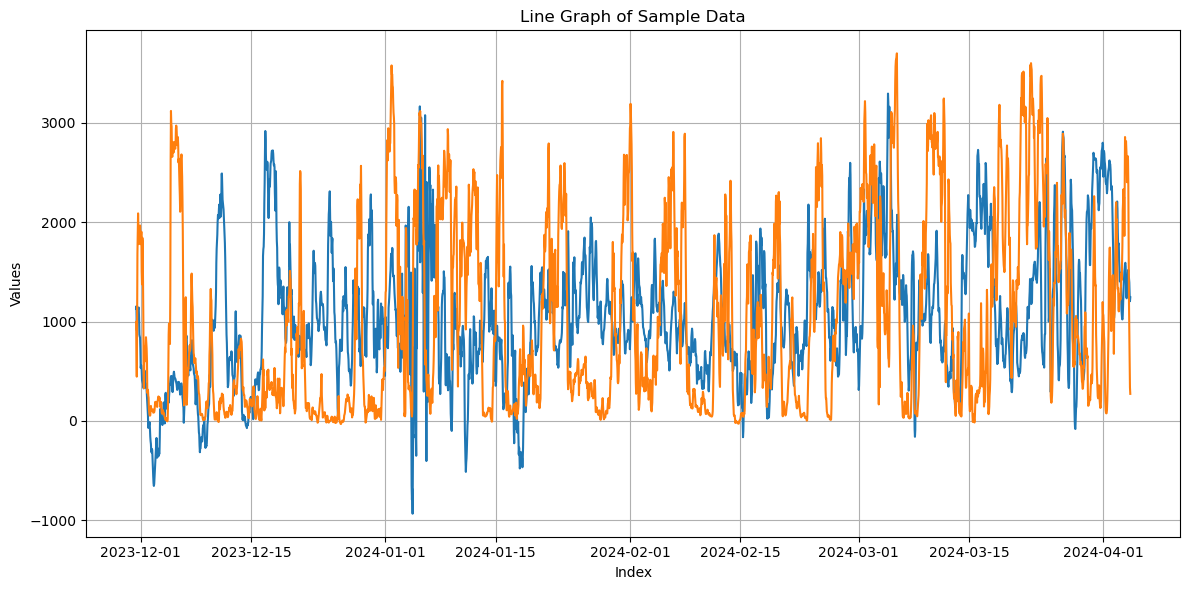

MSE between provided CNN prediction and actual MW is 1.0895151790980206


In [47]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([i for i in range(len(predictions_best))])
# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_best):], predictions_best.reshape(-1))
plt.plot(combined_actual['DATETIME'].iloc[-len(predictions_best):], scaler1.inverse_transform(y_test_1))
#plt.plot(combined_actual['DATETIME'].iloc[-len(predictions):], combined_dam['MW'].iloc[-len(predictions):])

plt.title('Line Graph of Sample Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.tight_layout()
plt.show()


error = mean_squared_error(y_test_1,predict) 
print("MSE between provided CNN prediction and actual MW is {}".format(error))



### Submit prediction

I used the current day's wind data and look back 24*3 hour to predict the wind for the next 48 hours.Therefore, I need data from previous 24*3 hours before 2024-04-07 to 2024-04-07 to predict the wind on 2024-04-09.


In [111]:
start_date = pd.to_datetime('2024-04-03').date()
end_date = pd.to_datetime('2024-04-07').date()

test1 = test[(test['DATETIME'].dt.date >= start_date) & (test['DATETIME'].dt.date <= end_date)]
test1 = test1[-24*4+1:]

In [112]:
X_Apr_07 = np.array(test1)[:,1:-1]
X_Apr_07_scaled = scaler.transform(X_Apr_07)
X_input = create_3d_dataset(X_Apr_07_scaled,time_step)


In [113]:
X_input.shape

(24, 72, 18)

In [114]:
wind_Apr_09 = model.predict(X_input)
predictions_Apr_09 = scaler1.inverse_transform(wind_Apr_09)

1/1 [==============================] - 0s 88ms/step


In [122]:
date = datetime(2024, 4, 9)

# Create the data for the DataFrame
df_pred = {
    'DATE': [date] * 24,
    'HE': list(range(1, 25)),
    'Trading_Hub': ['SP15'] * 24,
    'Renewable_Type': ['Wind'] * 24,
    'MW': predictions_Apr_09.reshape(-1)
}

# Create the DataFrame
df_pred = pd.DataFrame(df_pred)

In [124]:
df_pred.to_csv('2024-04-09_Pred_Tao_Wei.csv',index=False)

In [125]:
model

#### Save model

In [134]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

saveModel(model, model_path)

#model1= loadModel(model_path)   
#use it to load saved model

Directory .\final_model already exists, files will be over-written.
Model saved in directory .\final_model
